# Arrival Time Prediction - Prediction
This is the fourth and final notebook on GP regression for arrival time prediction. In this notebook we will finally make the predictions and take a look at the the residuals. First off we'll do the usual import stuff, and load the test data together with the synchonisation GPs trained in the previous notebook.

In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import scale
import time
import pickle
import tensorflow as tf
import gp_gpy as gp
import plot 

sns.set(style="darkgrid")
np.random.seed(1)
data = pd.read_pickle('train.pkl')
n_segs = data.seg.unique()
synch_traj_n = 7 # traj 7 was used to train synch gps
route_n = 3 # all data used currently is from route 3
data.head()

,lat,lon,traj,seg,speed,time_left,progress
0,15.565062,58.414597,1.0,2,4.62,52.0,0.000000
1,15.564899,58.414546,1.0,2,4.01,44.0,0.027778
2,15.564622,58.414425,1.0,2,-1.00,36.0,0.055556
3,15.564853,58.414530,1.0,2,2.93,34.0,0.083333
4,15.564763,58.414486,1.0,2,3.90,32.0,0.111111


## Training
The first step is to be able to compare a new trajectoy to trajectories trained on. To do this we fit a GP for the function $f : \tau \mapsto \mathcal{R}^2$ for each segment in each trajectory, which is the inverse of the synchronisation function. This will be used to compute the likelihood of a new trajectory once it has been synchronised, and then we can predict with the learned traectories that best explain it.

We will also need to fit a GP for each segment in each trajectory which makes the actual predictions, that is the function $f : \tau \mapsto \mathcal{R}$.

In [2]:
def synch_data(synch_gp, data):
    latlon  = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(latlon, axis=1)
    return synched_data
  
def train_gps(seg_n):
    seg = traj[traj.seg == seg_n]
    synch_gp = gp.load_synch(route_n, seg_n)
    synched_seg = synch_data(synch_gp, seg)
    n_restarts = 5
    
     # Learn GP to compute likelihood of new data
    likelihood_model = gp.build(
        synched_seg, 
        ['tau'],
        ['lat', 'lon'],
        'likelihood-v1',
        route_n, 
        traj_n, 
        seg_n)
    gp.train(likelihood_model, n_restarts)
    
    prediction_model = gp.build(
        synched_seg, 
        ['tau'], 
        ['time_left'], 
        'predict-v1', 
        route_n, 
        traj_n, 
        seg_n)    
    gp.train(prediction_model, n_restarts)
    return likelihood_model, prediction_model


n_trajs = data.traj.unique()
traj_n = n_trajs[0]
traj = data[data.traj == traj_n]
print(traj)
gp_tuples = [train_gps(seg_n) for seg_n in n_segs]

           lat        lon  traj  seg  speed  time_left  progress
0    15.565062  58.414597   1.0    2   4.62       52.0  0.000000
1    15.564899  58.414546   1.0    2   4.01       44.0  0.027778
2    15.564622  58.414425   1.0    2  -1.00       36.0  0.055556
3    15.564853  58.414530   1.0    2   2.93       34.0  0.083333
4    15.564763  58.414486   1.0    2   3.90       32.0  0.111111
5    15.564699  58.414459   1.0    2   4.88       31.0  0.138889
6    15.564622  58.414425   1.0    2   5.60       30.0  0.166667
7    15.564533  58.414387   1.0    2   6.37       29.0  0.194444
8    15.564433  58.414349   1.0    2   7.04       28.0  0.222222
9    15.564322  58.414307   1.0    2   7.51       27.0  0.250000
10   15.564214  58.414261   1.0    2   7.97       26.0  0.277778
11   15.564102  58.414215   1.0    2   8.48       25.0  0.305556
12   15.563983  58.414169   1.0    2   8.79       24.0  0.333333
13   15.563855  58.414120   1.0    2   9.25       23.0  0.361111
14   15.563716  58.414070

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -36.16983384475708
Optimization restart 4/5, f = -36.16983384475862
Optimization restart 5/5, f = -37.25365883095577
Optimization restart 1/5, f = -805.2428223406163
Optimization restart 2/5, f = -805.2428224111675
Optimization restart 3/5, f = -805.2428224178954
Optimization restart 4/5, f = -805.2428223186812
Optimization restart 5/5, f = -805.2427762561006
Optimization restart 1/5, f = -189.8777730749219
Optimization restart 2/5, f = -189.87777307549635
Optimization restart 3/5, f = -186.7110354337152
Optimization restart 4/5, f = -190.13738940312584
Optimization restart 5/5, f = -189.46366871503284


 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = -771.4458397644357
Optimization restart 2/5, f = -771.4458397734476
Optimization restart 3/5, f = -771.4458397825545
Optimization restart 4/5, f = -771.4458383360213
Optimization restart 5/5, f = -771.445839783343
Optimization restart 1/5, f = -91.5868238821088
Optimization restart 2/5, f = -91.58682388465638
Optimization restart 3/5, f = -91.58682388469737
Optimization restart 4/5, f = -91.58682388542792
Optimization restart 5/5, f = -91.58682388538614


 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = -904.1344700291638
Optimization restart 2/5, f = -904.1344700316151
Optimization restart 3/5, f = -904.1344700020301
Optimization restart 4/5, f = -904.1344700378291
Optimization restart 5/5, f = -904.1344700137696
Optimization restart 1/5, f = -123.38418354392789
Optimization restart 2/5, f = -120.84832366271085
Optimization restart 3/5, f = -120.84832366053146
Optimization restart 4/5, f = -123.38418354334995
Optimization restart 5/5, f = -123.38418354352414


 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = -391.8405926958593
Optimization restart 2/5, f = -391.8405920223737
Optimization restart 3/5, f = -391.84059903580277
Optimization restart 4/5, f = -391.8405970439677
Optimization restart 5/5, f = -391.84057093189233
Optimization restart 1/5, f = -97.90012511034
Optimization restart 2/5, f = -97.90012511023393
Optimization restart 3/5, f = -97.90012511027548
Optimization restart 4/5, f = -103.91078258756745


 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -103.91078258700212
Optimization restart 1/5, f = -2010.557460018677
Optimization restart 2/5, f = -2010.5574054504273
Optimization restart 3/5, f = -2010.557460050637
Optimization restart 4/5, f = -2010.5574600477794
Optimization restart 5/5, f = -2010.557460063677


 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 1/5, f = -544.8622423650239
Optimization restart 2/5, f = -443.9808828523055
Optimization restart 3/5, f = -544.8622423767289
Optimization restart 4/5, f = -443.98088285228977
Optimization restart 5/5, f = -443.9808828524173
Optimization restart 1/5, f = -671.7616584070876
Optimization restart 2/5, f = -671.7616583869716
Optimization restart 3/5, f = -671.7616584035982
Optimization restart 4/5, f = -671.7616584099998
Optimization restart 5/5, f = -671.7616583908742
Optimization restart 1/5, f = -123.91231470728005
Optimization restart 2/5, f = -123.91231470637942
Optimization restart 3/5, f = -123.91231470729105
Optimization restart 4/5, f = -123.91231470677383
Optimization restart 5/5, f = -123.91231470732706
Optimization restart 1/5, f = -622.3817939424717
Optimization restart 2/5, f = -622.3817939547539
Optimization restart 3/5, f = -622.3817939590351
Optimization restart 4/5, f = -622.3817939430878
Optimization restart 5/5, f = -622.3817939310564
Optimization r

Let's plot some of the GPs to see what they look like

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


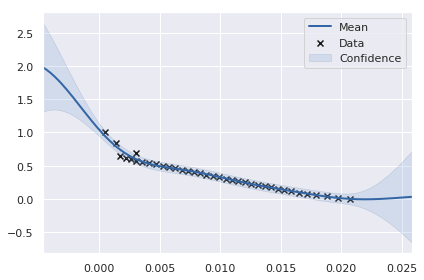

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


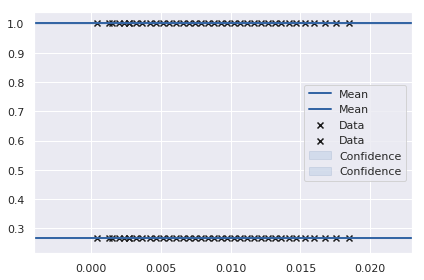

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


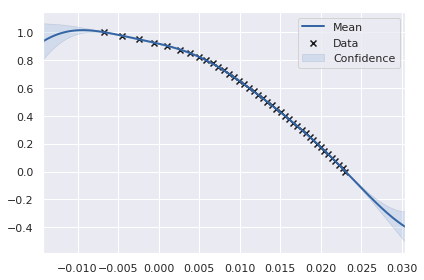

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


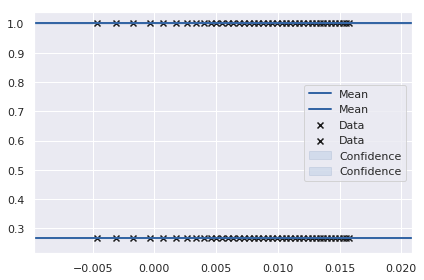

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


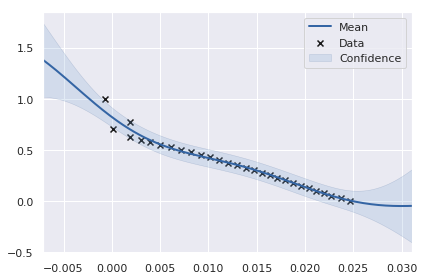

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


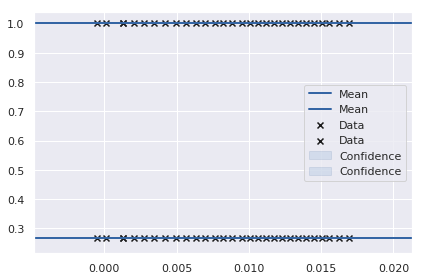

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


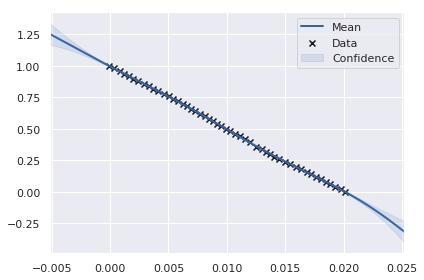

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


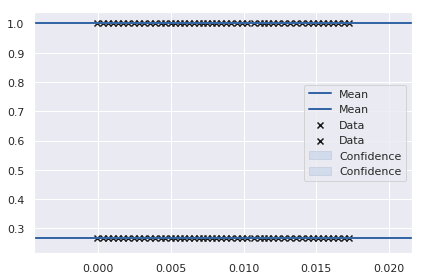

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


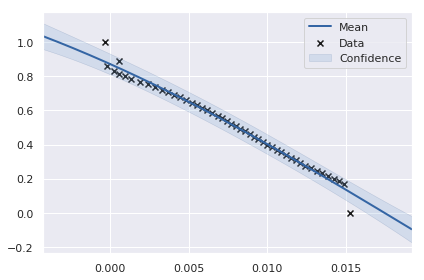

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


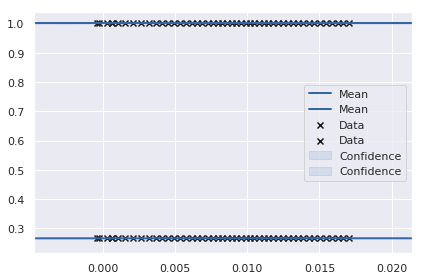

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


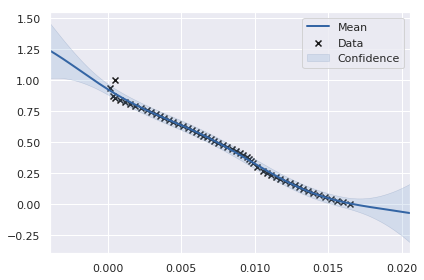

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


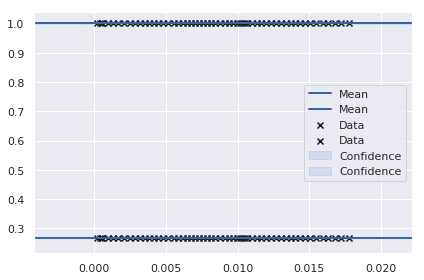

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


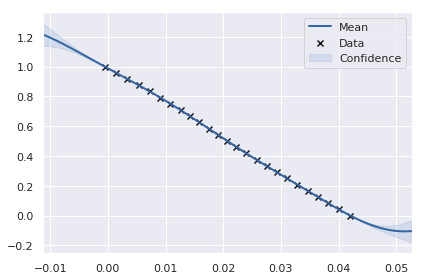

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


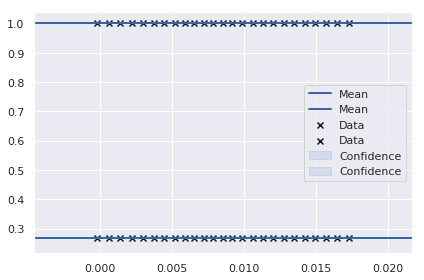

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


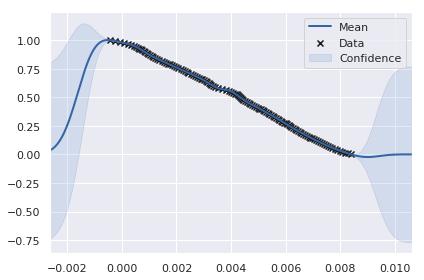

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


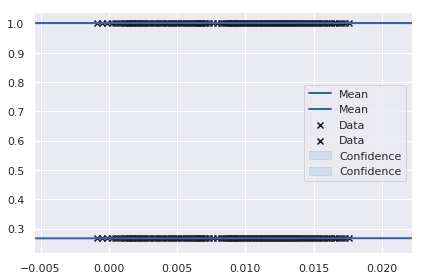

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


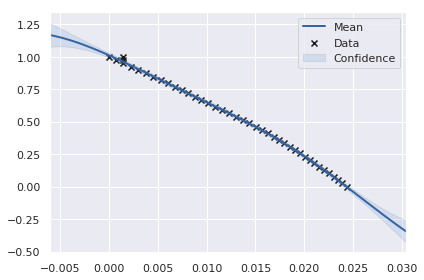

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


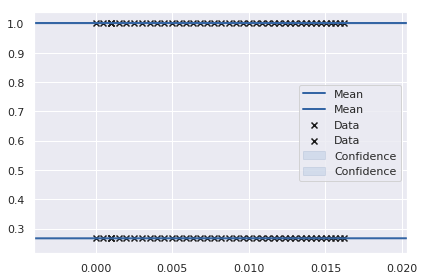

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


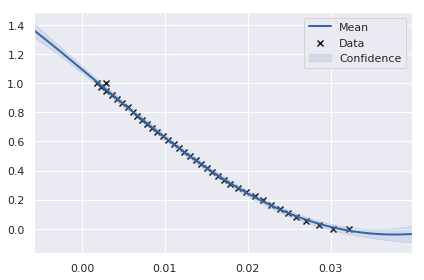

 /home/seba/anaconda3/envs/gp-busses/lib/python3.6/site-packages/matplotlib/figure.py:2359: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


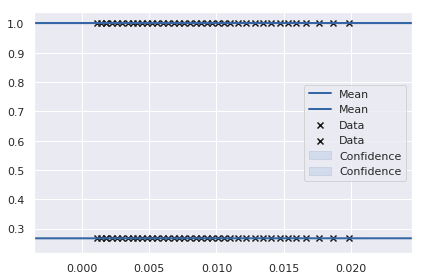

In [3]:
for lik_model, pred_model in gp_tuples:
    gp.plot(pred_model)
    gp.plot(lik_model)

The results for the prediction plots look really good, the ones for the likelihood is a bit harder to interpret. We'll save both do disk though.

In [4]:
for lik_model, pred_model in gp_tuples:
    gp.save(lik_model)
    gp.save(pred_model)

## Prediction
After having trained the GPs the model can now be presented with a new trajectory, look at the ones it has previously seen, rank them by likelihood and use them to make arrival time predictions.

In [5]:

def predict(traj, synch_gp, route_n, seg_n):
    synched_traj = synch_data(synch_gp, traj)
    models = gp.load_trajs('predict', route_n, seg_n)
    models_by_prob = most_likely_models(synched_traj, models)
    
    return models_by_prob

def most_likely_models(synched_traj, models):    
    def mk_model(m): 
        model = gp.build(synched_traj, ['tau'], ['lat', 'lon'], '', route_n, 0, seg_n)
        return gp.set_params(model, m.model.param_array)
    
    models_with_this_traj = [mk_model(m) for m in models]
    sorted_models = sorted(models_with_this_traj, key=gp.loglik, reverse=True)
    return [(m, np.exp(gp.loglik(m))) for m in sorted_models]

test = pd.read_pickle('test.pkl')
n_test_trajs = test.traj.unique()
n_test_segs = test.seg.unique()
seg_n = n_test_segs[0]
test_seg = test[(test.traj == n_test_trajs[0]) & (test.seg == seg_n)]
synch_gp = gp.load_synch(route_n, seg_n)
predict(test_seg, synch_gp, route_n, seg_n)

#predictions = [predict(learned_params, synch_gps, test_trajs[test_trajs.traj == traj_n]) for traj_n in n_test_trajs]


[(GP(model=<GPy.models.gp_regression.GPRegression object at 0x7fb32dec1400>, X=array([[0.00076873],
         [0.00234241],
         [0.00107091],
         [0.00173867],
         [0.00234241],
         [0.00285056],
         [0.00333504],
         [0.00386719],
         [0.00438171],
         [0.00490637],
         [0.00541248],
         [0.00589388],
         [0.00643261],
         [0.00691093],
         [0.00737907],
         [0.00783624],
         [0.00831107],
         [0.00878535],
         [0.00925567],
         [0.00974873],
         [0.0102452 ],
         [0.01076487],
         [0.01127285],
         [0.01178556],
         [0.01232341],
         [0.01293493],
         [0.01356612],
         [0.01429038],
         [0.01506471],
         [0.01597146],
         [0.01697423],
         [0.01805114],
         [0.01917819]]), Y=array([[0.26645593, 1.        ],
         [0.26645107, 0.99999772],
         [0.26645498, 0.99999946],
         [0.26645293, 0.99999851],
         [0.26645107, 